In [90]:
import os
import tempfile
from functools import partial
import datetime
import wandb
import matplotlib.pyplot as plt
import torch
import pathlib
import numpy as np
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger, WandbLogger
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from data.datasets import WeatherBenchModule
from models import LightningDRN, EmbeddingMLP
import scoringrules as sr
import xarray as xr
import cmcrameri
plt.rcParams['image.cmap'] = 'cmc.vik'


# Disable gradients
torch.set_grad_enabled(False)

In [91]:
grid = (160,220)
statistics = np.load("/home/groups/ai/datasets/weather_forecasting/era5_statistics.npy")
mean, std = statistics[0]

In [92]:
ck_path = "results/drn/checkpoints/mlp_2.ckpt"
checkpoint = torch.load(ck_path)

/tmp/ipykernel_991867/1290773009.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ck_path)


In [93]:
dm = WeatherBenchModule(train_batch_size=8192, num_workers = 12)

In [94]:
mlp = EmbeddingMLP()
model = LightningDRN(mlp)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [95]:
sample = dm.test_dataloader().dataset.__getitem__(10)
input, emb, target = sample
pred = model.predict_step(sample)
input.shape, pred.shape, target.shape

(torch.Size([35200, 5]), torch.Size([35200, 2]), torch.Size([35200, 1]))

In [96]:
mu, sigma = torch.split(pred, 1, -1)
mu = mu.squeeze(-1).reshape(grid).numpy()*std + mean - 273.15
sigma = sigma.squeeze(-1).reshape(grid).numpy()*std
target = target.squeeze().reshape(grid).numpy()* std + mean- 273.15
input = input[...,0].squeeze().reshape(grid).numpy()*std + mean- 273.15

Text(0.5, 1.0, 'Predicted Std Dev')

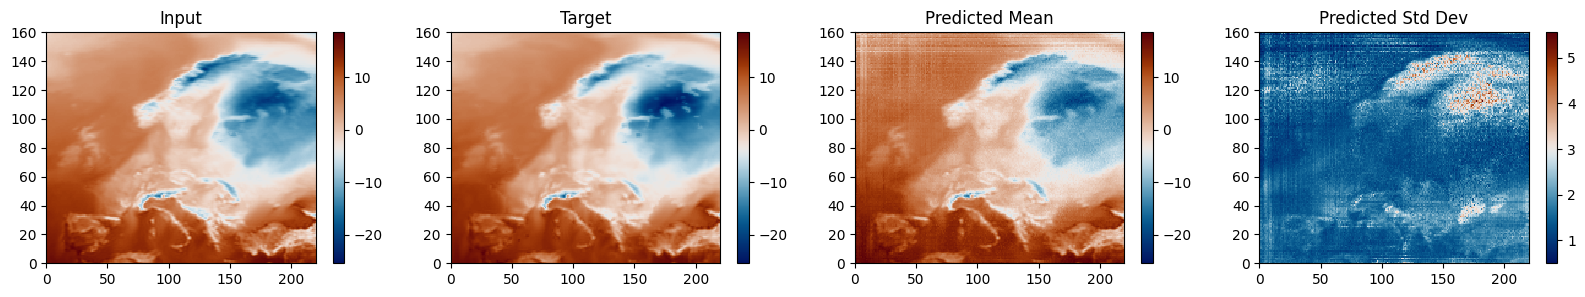

In [97]:
fig, axs = plt.subplots(1, 4, figsize=(20, 3))
min, max = target.min(), target.max()
im1 = axs[0].pcolormesh(input, vmin=min, vmax=max)
plt.colorbar(im1, ax=axs[0])
axs[0].set_title("Input")

im2 = axs[1].pcolormesh(target, vmin=min, vmax=max)
plt.colorbar(im2, ax=axs[1])
axs[1].set_title("Target")

im3 = axs[2].pcolormesh(mu, vmin=min, vmax=max)
plt.colorbar(im3, ax=axs[2])
axs[2].set_title("Predicted Mean")

im4 = axs[3].pcolormesh(sigma)
plt.colorbar(im4, ax=axs[3])
axs[3].set_title("Predicted Std Dev")


# Plot with iid mask

In [98]:
land_sea_mask = xr.open_zarr("/home/groups/ai/datasets/weather_forecasting/era5.zarr", consolidated=False).land_sea_mask.values
mask = np.where(land_sea_mask > 0.5, 1, 0)
orography = xr.open_zarr("/home/groups/ai/datasets/weather_forecasting/era5.zarr", consolidated=False)["geopotential_at_surface"].values / 9.80665

In [99]:
mu_masked = np.where(mask == 0, np.nan, mu)
sigma_masked = np.where(mask == 0, np.nan, sigma)
input_masked = np.where(mask == 0, np.nan, input)
target_masked = np.where(mask == 0, np.nan, target)

Text(0.5, 1.0, 'Predicted Std Dev')

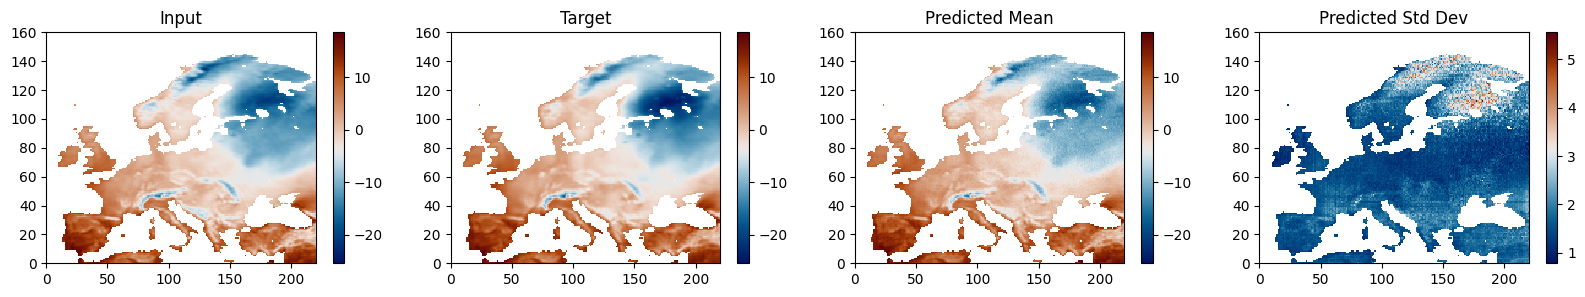

In [100]:
fig, axs = plt.subplots(1, 4, figsize=(20, 3))
min, max = target.min(), target.max()
im1 = axs[0].pcolormesh(input_masked, vmin=min, vmax=max)
plt.colorbar(im1, ax=axs[0])
axs[0].set_title("Input")

im2 = axs[1].pcolormesh(target_masked, vmin=min, vmax=max)
plt.colorbar(im2, ax=axs[1])
axs[1].set_title("Target")

im3 = axs[2].pcolormesh(mu_masked, vmin=min, vmax=max)
plt.colorbar(im3, ax=axs[2])
axs[2].set_title("Predicted Mean")

im4 = axs[3].pcolormesh(sigma_masked)
plt.colorbar(im4, ax=axs[3])
axs[3].set_title("Predicted Std Dev")

# Plot with OOD mask

In [101]:
mu_masked = np.where(mask == 1, np.nan, mu)
sigma_masked = np.where(mask == 1, np.nan, sigma)
input_masked = np.where(mask == 1, np.nan, input)
target_masked = np.where(mask == 1, np.nan, target)

Text(0.5, 1.0, 'Predicted Std Dev')

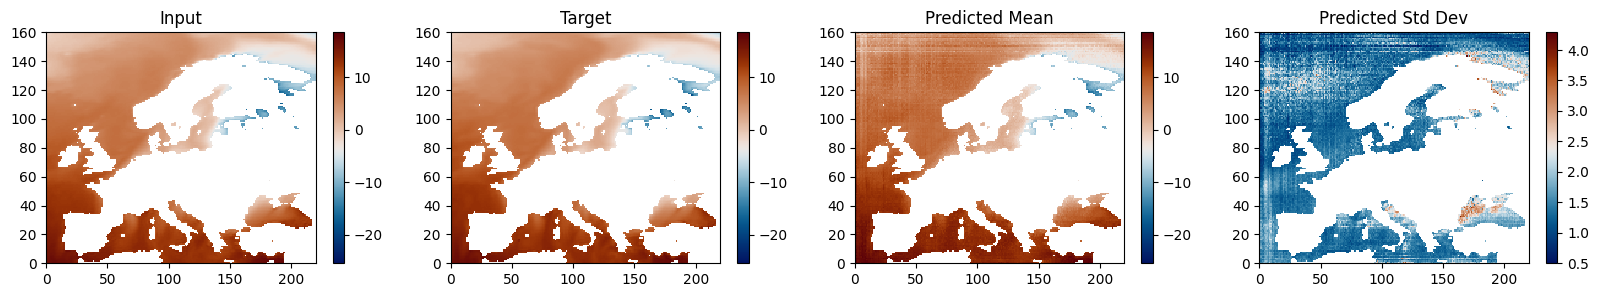

In [102]:
fig, axs = plt.subplots(1, 4, figsize=(20, 3))
min, max = target.min(), target.max()
im1 = axs[0].pcolormesh(input_masked, vmin=min, vmax=max)
plt.colorbar(im1, ax=axs[0])
axs[0].set_title("Input")

im2 = axs[1].pcolormesh(target_masked, vmin=min, vmax=max)
plt.colorbar(im2, ax=axs[1])
axs[1].set_title("Target")

im3 = axs[2].pcolormesh(mu_masked, vmin=min, vmax=max)
plt.colorbar(im3, ax=axs[2])
axs[2].set_title("Predicted Mean")

im4 = axs[3].pcolormesh(sigma_masked)
plt.colorbar(im4, ax=axs[3])
axs[3].set_title("Predicted Std Dev")

# Analyze uncertainties

In [103]:
mlp = EmbeddingMLP()
model = LightningDRN(mlp)
sample = dm.test_dataloader().dataset.__getitem__(10)
input, emb, target = sample

In [104]:
checkpoints = 3
results = np.zeros((checkpoints, 160,220, 2))
for i in range(checkpoints):
    ck_path = f"results/drn/checkpoints/mlp_{i}.ckpt"
    checkpoint = torch.load(ck_path)
    model.load_state_dict(checkpoint["state_dict"])
    pred = model.predict_step(sample)
    results[i] = pred.reshape(160,220,2)

/tmp/ipykernel_991867/1399483063.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ck_path)
/tmp/ipykernel_991867/1399483063.py:8: DeprecationWarni

In [105]:
au = (results[...,1]**2).mean(axis = 0)
au = np.where(land_sea_mask == 0, np.nan, au)
eu = results[...,0].var(axis = 0)

target = target.squeeze().reshape(grid).numpy()* std + mean- 273.15
input = input[...,0].squeeze().reshape(grid).numpy()*std + mean- 273.15

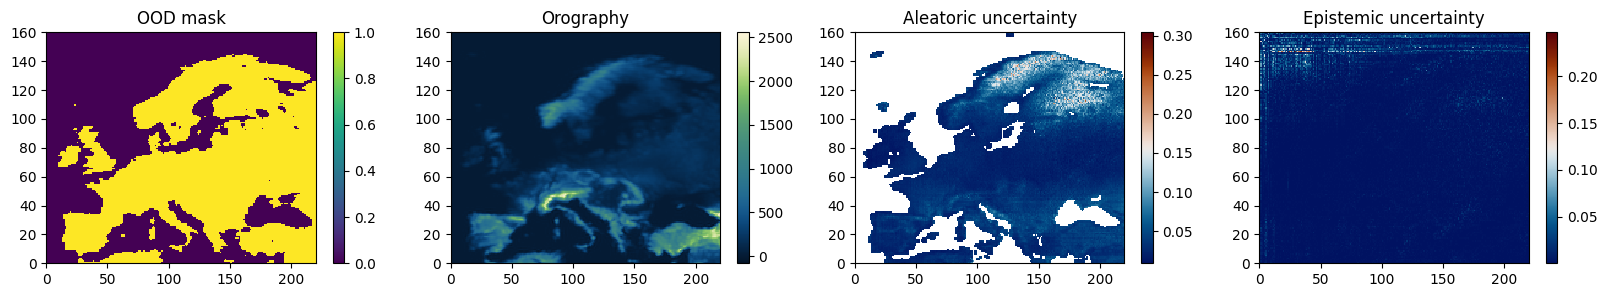

In [113]:
fig, axs = plt.subplots(1, 4, figsize=(20, 3))
im1 = axs[0].pcolormesh(mask, cmap = "viridis", rasterized = True)
plt.colorbar(im1, ax=axs[0])
axs[0].set_title("OOD mask")

im2 = axs[1].pcolormesh(orography, cmap = "cmc.navia", rasterized = True)
plt.colorbar(im2, ax=axs[1])
axs[1].set_title("Orography")

im3 = axs[2].pcolormesh(au, rasterized = True)
plt.colorbar(im3, ax=axs[2])
axs[2].set_title("Aleatoric uncertainty")

im4 = axs[3].pcolormesh(eu, rasterized = True)
plt.colorbar(im4, ax=axs[3])
axs[3].set_title("Epistemic uncertainty")

plt.savefig("plots/geospatial_uq.pdf", bbox_inches = "tight")